# LOADING DATASET

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, BooleanType, LongType

In [2]:
structure = StructType([
        StructField("overall", DoubleType(), True),
        StructField("vote", StringType(), True),
        StructField("verified", BooleanType(), True),
        StructField("reviewTime", StringType(), True),
        StructField("reviewerID", StringType(), True),
        StructField("asin", StringType(), True),
        StructField("reviewerName", StringType(), True),
        StructField("reviewText", StringType(), True),
        StructField("summary", StringType(), True),
        StructField("unixReviewTime", LongType(), True),
])

In [3]:
spark = SparkSession.builder.appName("Amazon_Reviews")\
                    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Project.AmazonReviews") \
                    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/Project.AmazonReviews") \
                    .getOrCreate()

In [4]:
df = spark.read.json("E:\dataset\All_Amazon_Review.json", schema = structure)

In [5]:
df.printSchema()

root
 |-- overall: double (nullable = true)
 |-- vote: string (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [6]:
df.show(5)

+-------+----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+
|overall|vote|verified| reviewTime|    reviewerID|      asin|    reviewerName|          reviewText|             summary|unixReviewTime|
+-------+----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+
|    1.0|null|   false|12 11, 2015|A27BTSGLXK2C5K|B017O9P72A|Jacob M. Wessler|Alexa is not able...|VERY Buggy, doesn...|    1449792000|
|    4.0|   5|   false| 12 8, 2015|A27ZJ1NCBFP1HZ|B017O9P72A|            Greg|Alexa works great...|      So Far So Good|    1449532800|
|    1.0|  11|   false| 12 7, 2015| ACCQIOZMFN4UK|B017O9P72A|        Da-Gr8-1|Weak!!\n\nAlexa d...|         Time waster|    1449446400|
|    2.0|null|   false| 12 5, 2015|A3KUPJ396OQF78|B017O9P72A|   Larry Russlin|Can only control ...|               Buggy|    1449273600|
|    1.0|   2|   false| 02 2, 2018|A1U1RE1ZI19E1

# CLEANING DATASET

In [7]:
df.withColumn("vote", df.vote.cast(IntegerType()))

DataFrame[overall: double, vote: int, verified: boolean, reviewTime: string, reviewerID: string, asin: string, reviewerName: string, reviewText: string, summary: string, unixReviewTime: bigint]

In [8]:
df = df.fillna({
    "overall": 0.0,
    "vote": 0,
    "verified": False,
    "reviewTime": "",
    "reviewerID": "",
    "asin": "",
    "reviewerName": "Anonymous",
    "reviewText": "",
    "summary": "",
    "unixReviewTime": ""
})

In [9]:
from pyspark.sql.functions import regexp_replace, col, lower
import string

df = df.withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]+", ""))
df = df.withColumn("reviewText", lower(col("reviewText")))
df = df.withColumn("summary", regexp_replace(col("summary"), "[^\w\s]+", ""))
df = df.withColumn("summary", lower(col("summary")))

In [10]:
from pyspark.sql.functions import when

df = df.withColumn("verified", when(df.verified == "True", 1).otherwise(0))

In [11]:
pandas_df = df.limit(50).toPandas()
display(pandas_df)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,1.0,0,0,"12 11, 2015",A27BTSGLXK2C5K,B017O9P72A,Jacob M. Wessler,alexa is not able to control my lights if i as...,very buggy doesnt work,1449792000
1,4.0,5,0,"12 8, 2015",A27ZJ1NCBFP1HZ,B017O9P72A,Greg,alexa works great for me so far but im also on...,so far so good,1449532800
2,1.0,11,0,"12 7, 2015",ACCQIOZMFN4UK,B017O9P72A,Da-Gr8-1,weak\n\nalexa doesnt even recognize the name l...,time waster,1449446400
3,2.0,0,0,"12 5, 2015",A3KUPJ396OQF78,B017O9P72A,Larry Russlin,can only control one of two bulbs from one of ...,buggy,1449273600
4,1.0,2,0,"02 2, 2018",A1U1RE1ZI19E1H,B017O9P72A,Rebekah,this worked great then randomly stopped please...,stopped working,1517529600
5,5.0,0,0,"01 15, 2018",A3TXR8GLKS19RE,B017O9P72A,Nello,great skill,great,1515974400
6,1.0,4,0,"01 5, 2018",AVIWE1LJXCG77,B017O9P72A,Pete Johnson,pretty crappy wonrsquot connect with alexis,returning to,1515110400
7,1.0,2,0,"01 4, 2018",A1FOHYK23FJ6CN,B017O9P72A,L. Ray Humphreys,not happy can not connect to alexa regardless,can not connect to echo,1515024000
8,1.0,5,0,"12 30, 2017",A1RRDX9AOST1AN,B017O9P72A,Viola,can not connect a hue lights to alexa linked t...,connecting is a no go,1514592000
9,1.0,5,0,"12 29, 2017",AA4DHYT5YSSIT,B017O9P72A,angie anj,the service works with google home but doesnt ...,does not work,1514505600


# LOADING DATA IN MONGODB

In [12]:
mongo_uri = "mongodb://localhost:27017/Project.AmazonReviews"

In [13]:
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", mongo_uri).save()

# EXPLORATORY DATA ANALYSIS

In [4]:
df1 = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [8]:
df2 = df1.limit(500000).toPandas()
display(pandas_df)

,_id,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,verified,vote
0,"(644f9754c68553496c4afc81,)",B01C6DXMX0,5.0,love this product,"09 26, 2017",A1MWPEXTKRZTVU,cherie,five stars,1506384000,0,0
1,"(644f9754c68553496c4afc82,)",B01C6DXMX0,4.0,great product easy to install,"09 25, 2017",A15Q1O8A4WWL0M,Greg Willis,great product easy to install,1506297600,0,0
2,"(644f9754c68553496c4afc83,)",B01C6DXMX0,5.0,it just works great,"09 24, 2017",A1K0Z9BW3SYMBB,Alan L.,five stars,1506211200,0,0
3,"(644f9754c68553496c4afc84,)",B01C6DXMX0,5.0,this camera works very well the videos are ver...,"09 24, 2017",A2NIFC4XEWL3EC,BMW,good quality,1506211200,1,0
4,"(644f9754c68553496c4afc85,)",B01C6DXMX0,4.0,the ring was recommended to us now we recommen...,"09 21, 2017",A2DZJOWG035M7G,Jmol,the ring was recommended to us,1505952000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
499995,"(644f975dc68553496c529d9c,)",B00J46VVKE,5.0,perfect great price works extremely well,"11 15, 2015",A36P81T1D7ICSX,Amazon Customer,dont buy name brand this works perfect,1447545600,1,0
499996,"(644f975dc68553496c529d9d,)",B00J46VVKE,1.0,doesnt work after 2 months of use return perio...,"11 15, 2015",A33HVE01313PUN,mbt,piece of junk,1447545600,1,0
499997,"(644f975dc68553496c529d9e,)",B00J46VVKE,5.0,i bought this product based on the amazon revi...,"11 15, 2015",A1D9F5NX3YIRR,From Illinois,very satisfied with this product,1447545600,1,0
499998,"(644f975dc68553496c529d9f,)",B00J46VVKE,5.0,i have been using this charger for months now ...,"11 14, 2015",A7B2VKET6AS5E,Amy,works just as great as my apple charger,1447459200,1,0


# PLOT OF SENTIMENT OF REVIEWS

In [ ]:
#Fethching data for below analyzation

# ratings = df.groupBy('overall').count().orderBy('overall')

# ratings_pd = ratings.toPandas()

#I commented the Code because i have retrieved the output and stored it in csv for my easiness.

In [ ]:
#Converting the dataframe to csv for future use

#ratings_pd.to_csv('C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Distribution_Overall_Dataset.csv', index=False)

C:\Users\Administrator.TAYYAB-JMP-DEMO\AppData\Local\Temp\2\ipykernel_2812\3471557886.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


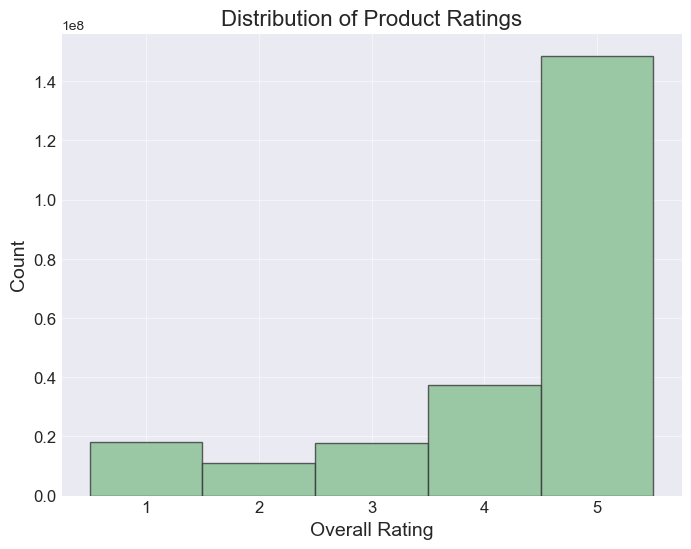

In [10]:
# This analysis tells about the sentiment of Reviews in the dataset by checking overall column. As there are ratings in the overall so this
# this histogram tell us that most of the products are reviewed positively and the distribution of Product ratings
# if we analyze according to the overall column.
# I read the csv I made above for Matplot

ratings_pd=pd.read_csv(r'C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Distribution_Overall_Dataset.csv')

plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(ratings_pd['overall'], bins=5, range=(0.5, 5.5), weights=ratings_pd['count'],
        color='#86bf91', edgecolor='#383838', alpha=0.8)

ax.set_xlabel('Overall Rating', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Distribution of Product Ratings', fontsize=16)

ax.grid(True, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()
#Most of the products of dataset are reviewed 5 rated.


# SCATTER PLOT OF REVIEWS VS REVIEW LENGTH

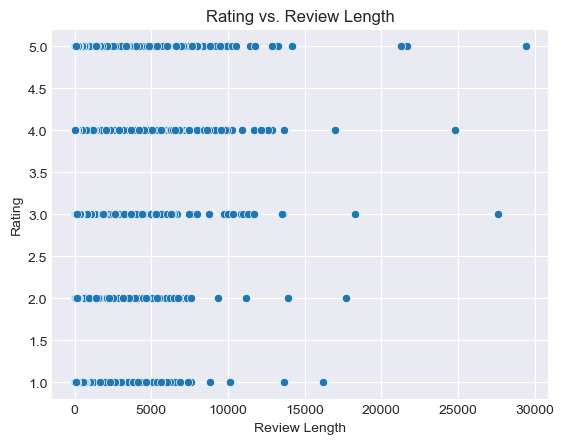

In [17]:
import seaborn as sns

df2['review_len'] = df2['reviewText'].str.len()
sns.scatterplot(data = df2, x = 'review_len', y = 'overall')
plt.title('Rating vs. Review Length')
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.show()

# TOP 10 MOST REVIEWED PRODUCTS

In [ ]:
# Here I have grouped data according to the most reviews on a product to check top 10 products according to number of reviews
# of the products.
from pyspark.sql.functions import *

review_counts = df1.groupBy('asin').agg(count('*').alias('review_count'))

# Sort the results in descending order by review count and take the top 10 products
top_10_products = review_counts.orderBy(desc('review_count')).limit(10)

# Join the top 10 products with the original DataFrame to obtain their average overall rating
average_overall = top_10_products.join(df, 'asin').groupBy('asin').agg(avg('overall').alias('avg_overall'))

# Show the results
average_overall.show()


 
 # Here I have top 10 products with most reviews. Below I calculated avg overall of top 10 products.


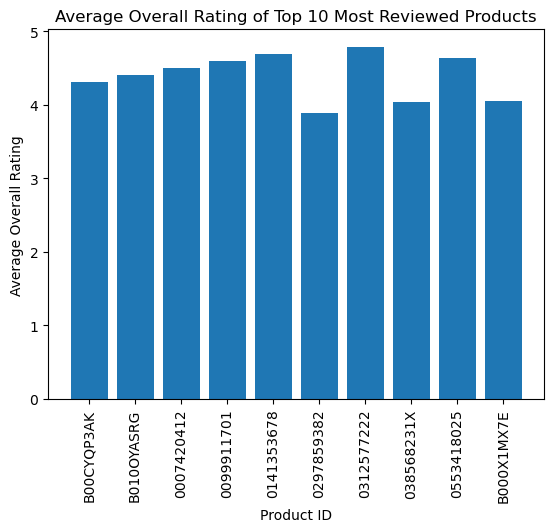

In [8]:
# Above I analyzed top 10 products according to the number of reviews and now I will plot a graph to analyze the sentiment of the 
# top 10 products to see if the most reviewed products were good for people or not and this analyzation will also tell us that if
# the most reviewed products will be more profitable and beneficial in future or not.
# I will analyze the sentiment of top 10 products reviewed using the overall column cause it tells us what people rated the product.
# I will take the average overall of the products to conclude whether product will be beneficial in future or not.


#Getting the Average overall for the top 10 products
#average_overall = top10Products.join(df, 'asin').groupBy('asin').agg(avg('overall').alias('avg_overall'))

#Below I will convert in to pandas then to csv for future use.

#Conversion to Pandas
#avgPd=average_overall.toPandas()

#Conversion of data Frame to csv for future use
#avgPd.to_csv('C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Average_Sentiment.csv', index=False)


# Reading the csv I made
avgPd = pd.read_csv(r'C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Average_Sentiment.csv')

plt.bar(avgPd["asin"], avgPd["avg_overall"])

plt.title('Average Overall Rating of Top 10 Most Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Average Overall Rating')

plt.xticks(rotation=90)

plt.show()

#Below you can see how much the top 10 reviewed products are rated on average.


#I have commented the code because i have stored the outputs in csv files for plotting. 

# TOP 10 LEAST REVIEWED PRODUCTS

In [ ]:
# Now I will fetch the data of top 10 most least reviewed number products and check if the rating they got was good or bad
# and will they be beneficial for future or not.
# This will give me the sentiment that whether customers likes the product or not.

from pyspark.sql.functions import *

reC = df1.groupBy('asin').agg(count('*').alias('newC'))


src = reC.orderBy("newC")

# Only getting first 10 rows and the rows are in sorted order.
lst = src.limit(10)

# Fetching the average overall of the least reviewed products.
res = lst.join(df, 'asin').groupBy('asin').agg(avg('overall').alias('avg_overall'))



In [ ]:
#Converting spark dataframe to pandas
#leastProd=res.toPandas()

In [ ]:
#Stored it in to dataframe 
#leastProd.to_csv('C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Least_Average_Sentiment.csv')

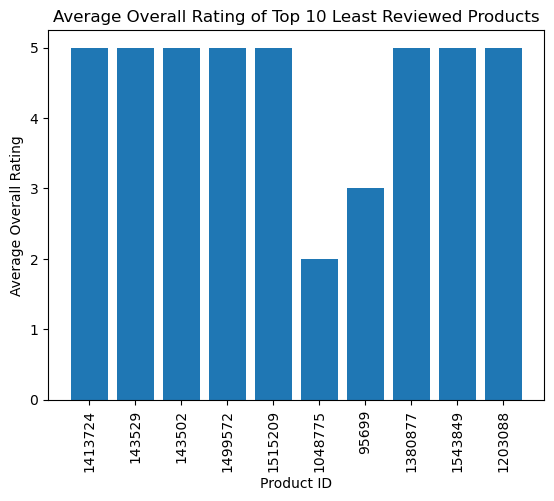

In [9]:
lstProd = pd.read_csv(r'C:\Users\Administrator.TAYYAB-JMP-DEMO\Desktop\Least_Average_Sentiment.csv')

lstProd['asin'] = lstProd['asin'].astype(str)

plt.bar(lstProd['asin'], lstProd["avg_overall"])

plt.title('Average Overall Rating of Top 10 Least Reviewed Products')
plt.xlabel('Product ID')
plt.ylabel('Average Overall Rating')

plt.xticks(rotation=90)

plt.show()

# So as can be seen products with less number of reviews are rated at the average of 5 but as seen in graph there are two products
# 1048775 is averagely rated 2 and 95699 is rated averagely 3 so these products are not that good for money.